In [1]:
# Compare two matchms tables

In [95]:
from pipeline_utils import get_galaxy_filename
import numpy as np
import pandas as pd
from matplotlib_venn import venn2 as venn2_
import matplotlib.pyplot as plt


def venn2(*args,):
    v = venn2_(*args, set_labels = ('Predicted', 'Ground'))
    v.get_patch_by_id('100').set_color('red')
    v.get_patch_by_id('010').set_color('orange')
    v.get_patch_by_id('110').set_color('green')

In [119]:
model = "MLP .1"

fres1 = get_galaxy_filename('- Original', 'tmp', None)
fres2 = get_galaxy_filename(f'- {model}', 'tmp', None)

fref = "tmp/6_KC_Confirmed_seminalplasma.csv.csv"



# reference_lib = "../data/1_rcx_gc-orbitrap_metabolites_20210817.msp.msp"
# concs = ["all"]
# # if the predictions were generated in this galaxy session set to True
# is_fresh = False
# suffix = "" if is_fresh else ".txt"


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [120]:
fres1

'tmp/1_matchms output formatter _get-thresholded-data_ on data 129 and data 128 - Original.tsv'

In [121]:
ref = pd.read_csv(fref)
res1 = pd.read_csv(fres1, sep="\t")
res2 = pd.read_csv(fres2, sep="\t")

In [122]:
len(res1.groupby("query").mean())

41

In [123]:
len(res1), len(res2)

(143, 139)

In [124]:
th_m = 1
th_s = 0.1


### First eval: only set:

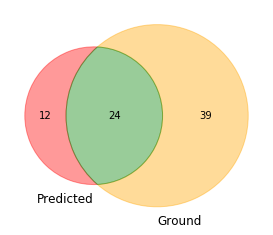

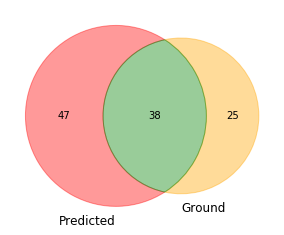

In [125]:
ground = set(ref["Metabolite name"])
orig = set(res1.reference) 
new = set(res2.reference) 

orig = res1[((res1.matches > th_m) & (res1.score > th_s))].reference
venn2((set(orig), ground))
plt.show()
venn2((set(new), ground))

### Second eval: take the best compound for each spectra and set compare

In [126]:
# add helper collumn - the best criterion in the score as in rcx galaxy formatter
res1["total"] = res1["score"]
res2["total"] = res2["score"]#

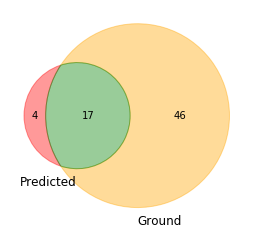

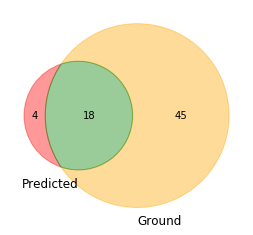

In [127]:
x  = res1[((res1.matches > th_m) & (res1.score > th_s))]

x = x.loc[x.groupby('query')['total'].idxmax(), ['query', 'reference', 'total']]
orig = x.reference

venn2((set(orig), ground))
plt.show()

x  = res2[((res2.matches > th_m) & (res2.score > th_s))]

x = x.loc[x.groupby('query')['total'].idxmax(), ['query', 'reference', 'total']]
new = x.reference
venn2((set(new), ground))

### Third eval: take the best compound for each spectra and compare with maximal RI difference

In [128]:
import sys
sys.path.append("..")

import pandas as pd
import matchms
from matchms.importing import load_from_msp
from data_utils import spectrum_processing
from pipeline_utils import get_galaxy_filename

def get_spectra(path):
    spectrums = [spectrum_processing(s, min_rel_int=None, n_required_peaks=1) for s in load_from_msp(path, metadata_harmonization=False)]
    # Omit spectrums that didn't qualify for analysis
    spectrums = [s for s in spectrums if s is not None]
    return spectrums

# super inefficent variant :))
def get_RTI(c_ids, measured):
    rts =[]
    ris = []
    for c_id in c_ids:
        for spectrum in measured:
            if c_id == spectrum.metadata["compound_name"]:
                rts.append(spectrum.metadata["retention_time"])
                ris.append(float(spectrum.metadata["retention_index"]))
                break
    return rts, ris

In [129]:
ref[["Metabolite name", "Average RI"]]

,Metabolite name,Average RI
0,2-Methylmalonic acid_2TMS,1224.68
1,Acetylgalactosamine_4TMS,2071.84
2,Acetylgalactosamine_5TMS isomer 1,2065.37
3,Acetylgalactosamine_5TMS isomer 2,2088.77
4,Acetylglucosamine_5TMS isomer 1,2070.17
...,...,...
60,Threonine_3TMS spectra 1,1377.14
61,Threonine_3TMS spectra 2,1378.30
62,trans-Aconitic acid_3TMS,1732.44
63,Tryptophan_3TMS,2208.86


In [130]:
# add helper colums - measured spectrum RI, ground compound RI
library = get_spectra("tmp/5_rcx_gc-orbitrap_metabolites_20210817.msp.msp")
measured1 = get_spectra(get_galaxy_filename(f"_Original", "tmp"))
measured2 = get_spectra(get_galaxy_filename(f"_{model}", "tmp"))

enh = []
for res, mes in zip([res1, res2], [measured1, measured2]):
    res["measured_RI"] = get_RTI(res["query"], mes)[1]
    
    tmp = ref.rename(columns={"Metabolite name": "reference", "Average RI": "ground_RI"})
    enh.append(pd.merge(tmp[["reference", "ground_RI"]], res, how="right", on="reference"))
    enh[-1].loc[pd.isna(enh[-1].ground_RI), "ground_RI"] = -1000
    enh[-1]["RI_diff"] = abs(enh[-1]["ground_RI"] - enh[-1]["measured_RI"])   
res1, res2 = enh

In [131]:
res1

,reference,ground_RI,query,matches,score,total,measured_RI,RI_diff
0,Myristic acid_1TMS,-1000.00,C01,1,0.004459,0.004459,1824.952381,2824.952381
1,Acetylglutamine_2TMS,-1000.00,C02,3,0.014779,0.014779,1917.708333,2917.708333
2,Ascorbic acid_4TMS,-1000.00,C02,1,0.001019,0.001019,1917.708333,2917.708333
3,Galactose_5TMS isomer 2,-1000.00,C02,1,0.001280,0.001280,1917.708333,2917.708333
4,Gluconolactone,-1000.00,C02,2,0.009801,0.009801,1917.708333,2917.708333
...,...,...,...,...,...,...,...,...
142,Arginine_3TMS,1808.41,C66,3,0.027802,0.027802,1818.333333,9.923333
143,Citric acid_4TMS,1800.10,C66,1,0.157394,0.157394,1818.333333,18.233333
144,Isocitric acid_4TMS,-1000.00,C66,2,0.014122,0.014122,1818.333333,2818.333333
145,Myristic acid_1TMS,-1000.00,C67,3,0.011347,0.011347,1848.666667,2848.666667


In [132]:
max_RI_diff = 30

sum(abs(res2["RI_diff"]) >max_RI_diff)
# assert sum(abs(res2["ground_RI"] - res2["measured_RI"]) >max_RI_diff) == 0


70

In [133]:
res1

,reference,ground_RI,query,matches,score,total,measured_RI,RI_diff
0,Myristic acid_1TMS,-1000.00,C01,1,0.004459,0.004459,1824.952381,2824.952381
1,Acetylglutamine_2TMS,-1000.00,C02,3,0.014779,0.014779,1917.708333,2917.708333
2,Ascorbic acid_4TMS,-1000.00,C02,1,0.001019,0.001019,1917.708333,2917.708333
3,Galactose_5TMS isomer 2,-1000.00,C02,1,0.001280,0.001280,1917.708333,2917.708333
4,Gluconolactone,-1000.00,C02,2,0.009801,0.009801,1917.708333,2917.708333
...,...,...,...,...,...,...,...,...
142,Arginine_3TMS,1808.41,C66,3,0.027802,0.027802,1818.333333,9.923333
143,Citric acid_4TMS,1800.10,C66,1,0.157394,0.157394,1818.333333,18.233333
144,Isocitric acid_4TMS,-1000.00,C66,2,0.014122,0.014122,1818.333333,2818.333333
145,Myristic acid_1TMS,-1000.00,C67,3,0.011347,0.011347,1848.666667,2848.666667


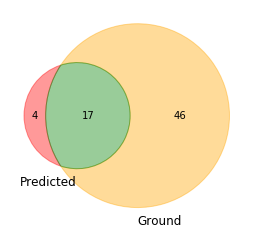

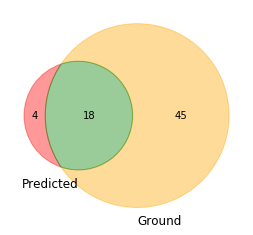

In [134]:
x = res1[((res1.matches > th_m) & (res1.score > th_s))]
x = x.loc[x.groupby('query')['total'].idxmax(), ['query', 'reference', 'total', "RI_diff"]]
x.loc[x.RI_diff > max_RI_diff, "reference"] += "x"
orig = x.reference

venn2((set(orig), ground))
plt.show()

x  = res2[((res2.matches > th_m) & (res2.score > th_s))]
x = x.loc[x.groupby('query')['total'].idxmax(), ['query', 'reference', 'total', "RI_diff"]]
x.loc[x.RI_diff > max_RI_diff, "reference"] += "x"
new = x.reference
venn2((set(new), ground))

In [135]:
set(new).difference(orig)

{'Leucine_2TMS'}

In [136]:
set(orig).difference(new)

set()

In [137]:
set(orig).intersection(ground)

{'Acetylgalactosamine_5TMS isomer 1',
 'Acetylglucosamine_5TMS isomer 1',
 'Asparagine_3TMS',
 'Aspartic acid_3TMS isomer',
 'Citric acid_4TMS',
 'Creatinine_3TMS',
 'Fructose_5TMS isomer 2',
 'Glycine_3TMS',
 'Histidine_3TMS',
 'Lysine_4TMS',
 'Myo-inositol_6TMS',
 'Palmitic acid_1TMS',
 'Phenylalanine_2TMS',
 'Serine_3TMS',
 'Stearic acid_1TMS',
 'Threonine_3TMS spectra 1',
 'Tyrosine_3TMS'}

In [138]:
set(new).intersection(ground)

{'Acetylgalactosamine_5TMS isomer 1',
 'Acetylglucosamine_5TMS isomer 1',
 'Asparagine_3TMS',
 'Aspartic acid_3TMS isomer',
 'Citric acid_4TMS',
 'Creatinine_3TMS',
 'Fructose_5TMS isomer 2',
 'Glycine_3TMS',
 'Histidine_3TMS',
 'Leucine_2TMS',
 'Lysine_4TMS',
 'Myo-inositol_6TMS',
 'Palmitic acid_1TMS',
 'Phenylalanine_2TMS',
 'Serine_3TMS',
 'Stearic acid_1TMS',
 'Threonine_3TMS spectra 1',
 'Tyrosine_3TMS'}

In [139]:
set(new).difference(orig).intersection(ground)

{'Leucine_2TMS'}

### Final eval: take the n best compound for each spectra and compare with maximal RI difference

In [116]:


# different perspective - how much of recovered spectra were sucesfully matched?
# i sucessful mathcing is if the correct compound is matched in top 3(5) compounds sorted by score now
# the linking of detected spectra to annotations is via RT



In [38]:
set(new).intersection(ground)

{'Acetylgalactosamine_5TMS isomer 1',
 'Acetylglucosamine_5TMS isomer 1',
 'Asparagine_3TMS',
 'Aspartic acid_3TMS isomer',
 'Citric acid_4TMS',
 'Creatinine_3TMS',
 'Fructose_5TMS isomer 2',
 'Glutamic acid_3TMS spectra 2',
 'Glycine_3TMS',
 'Histidine_3TMS',
 'Leucine_2TMS',
 'Lysine_4TMS',
 'Myo-inositol_6TMS',
 'Palmitic acid_1TMS',
 'Phenylalanine_2TMS',
 'Serine_3TMS',
 'Stearic acid_1TMS',
 'Threonine_3TMS spectra 1'}

In [39]:
orig = np.zeros(shape=(20, 20))
new = orig.copy()

stat_orig = np.ones(63) * (100)
stat_new = stat_orig.copy()
for i, n_m in enumerate(range(1,21)):
    for j, n_s in enumerate(np.arange(0,1,0.05)):
        for res, grid, stat in zip([res1, res2], [orig, new], [stat_orig, stat_new]):
            p = set(res[((res.matches > n_m) & (res.score > n_s))].reference)
            
            x  = res[((res.matches > n_m) & (res.score > n_s))]
            x = x.reset_index()

            x = x.loc[x.groupby('query')['total'].idxmax(), ['query', 'reference', 'total']]
            p = set(x.reference)
            
            TP = len(p.intersection(ground))
            FP = len(p.difference(ground))
            FN = len(ground.difference(p))
            stat[TP] = min(FP, stat[TP])
            grid[i,j] = TP/(TP + 0.5*(FN+FP)) if (TP + 0.5*(FN+FP)) != 0 else 0
stat_orig[stat_orig == 100] = np.nan
stat_new[stat_new == 100] = np.nan

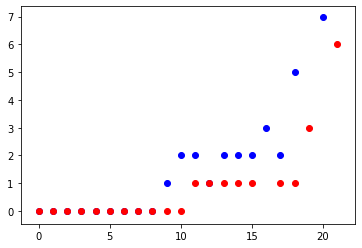

In [40]:
plt.scatter(x=np.arange(63), y=stat_orig, color="blue")
plt.scatter(x=np.arange(63), y=stat_new, color = "red")

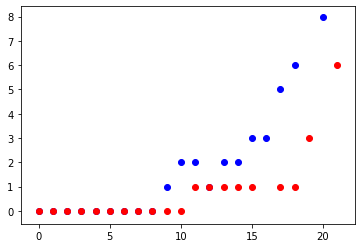

In [149]:
plt.scatter(x=np.arange(63), y=stat_orig, color="blue")
plt.scatter(x=np.arange(63), y=stat_new, color = "red")

In [43]:
stat_orig - stat_new

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  1.,  0.,
        1.,  1.,  1., nan,  1.,  4., nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

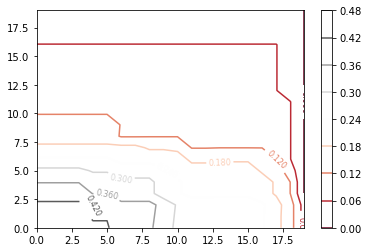

In [44]:
c = plt.contour(new, cmap='RdGy')
plt.clabel(c, inline=True, fontsize=8)

plt.colorbar()

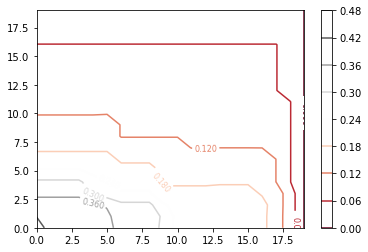

In [45]:
c = plt.contour(orig, cmap='RdGy')
plt.clabel(c, inline=True, fontsize=8)

plt.colorbar()


In [46]:
new.sum()

56.818564573400565

In [47]:
orig.sum()

50.58450836858507

In [48]:
th_m, th_s = 5, 0.4
orig = res1[((res1.matches > th_m) & (res1.score > th_s))].reference
new = res2[((res2.matches > th_m) & (res2.score > th_s))].reference


In [49]:
set(orig) -set(new)

set()

In [50]:
set(new) -set(orig)

{'Acetylgalactosamine_4TMS',
 'Acetylgalactosamine_5TMS isomer 1',
 'Aspartic acid_3TMS isomer',
 'Glutamic acid_3TMS spectra 1',
 'Glutamic acid_3TMS spectra 2',
 'Palmitic acid_1TMS'}

In [51]:
set(new) - ground

{'Gluconic acid-1,4-lactone',
 'Glucuro-3,6-lactone_3TMS isomer 1',
 'Glutamic acid_3TMS spectra 1',
 'Isocitric acid_4TMS',
 'Uridine_4TMS isomer 1'}

In [52]:
set(orig) - ground

{'Gluconic acid-1,4-lactone',
 'Glucuro-3,6-lactone_3TMS isomer 1',
 'Isocitric acid_4TMS',
 'Uridine_4TMS isomer 1'}

In [188]:
!pwd

/mnt/volume/shared/ces-nya/nfs4/home/umsa/job_working_directory_object/034/34762/working/jupyter/raims
